# clean data (from stored CSVs), add calculated fields, save new CSV

ref: https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

## imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## load data

In [3]:
# these are here for reference. They will be loaded individually below
# df_zillow = pd.read_csv('zillow1.csv')
# df_fields = pd.read_csv('fields1.csv')
# df_census = pd.read_csv('census1.csv')

## zillow
* An important list below is "years". The Zillow data (as of this writing) contains months from 2000-01-31 to 2023-08-31.
* Our census data runs 2012-2021 so we'll use Zillow data for 2012-2022 (use 2022 so we can see how much prices went up from 2021)
* We'll use the December value for each year.

In [4]:
# I will drop the 2022 rows later -- they are not in the census data but used for change in price
years = list(range(2012, 2023))

In [5]:
df_zillow = pd.read_csv('zillow1.csv')

remove columns, rename cols, check for nulls

In [6]:
df_zillow.rename(columns = {'RegionName':'zipcode', 
                            'State':'state', 
                            'City':'city', 
                            'Metro':'metro', 
                            'CountyName':'county'}, inplace = True)
for year in years:
    df_zillow.rename(columns = {str(year)+'-12-31':str(year)}, inplace = True)
cols = ['zipcode', 'state', 'city', 'metro', 'county']
for year in years:
    cols.append(str(year))
df_zillow = df_zillow[cols]
# df_zillow.head()

melt

In [7]:
df_z2 = df_zillow.melt(id_vars=['zipcode', 'state', 'city', 'metro', 'county'],
                    value_vars=[str(year) for year in years],
                    var_name='year',
                    value_name='typ_price')
df_z2.head()
# df_z2.info() # some prices are null

,zipcode,state,city,metro,county,year,typ_price
0,77494,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2012,260778.101018
1,8701,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,2012,224354.861939
2,77449,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,2012,111744.277322
3,11368,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2012,285571.388130
4,77084,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,2012,114189.161236


In [8]:
df_z2['year'] = df_z2['year'].astype(int)

add price changes in percent. We are interested in what conditions today lead to future price changes.

In [9]:
# not sure I will need all of these (up to 10 year price differences)
df_z2 = df_z2.sort_values(by=['zipcode', 'year'])
for i in range(1,max(years)-min(years)+1):
    df_z2['pct_next_'+ str(i) + 'yr'] = (df_z2.groupby('zipcode')['typ_price'].shift(-i) - df_z2['typ_price'])/df_z2['typ_price']
df_z2.head(12)

,zipcode,state,city,metro,county,year,typ_price,pct_next_1yr,pct_next_2yr,pct_next_3yr,pct_next_4yr,pct_next_5yr,pct_next_6yr,pct_next_7yr,pct_next_8yr,pct_next_9yr,pct_next_10yr
7354,1001,MA,Agawam,"Springfield, MA",Hampden County,2012,182105.827087,0.014960,0.009350,0.045878,0.099279,0.135675,0.176773,0.227829,0.334437,0.461720,0.600952
33727,1001,MA,Agawam,"Springfield, MA",Hampden County,2013,184830.039596,-0.005527,0.030463,0.083077,0.118936,0.159429,0.209732,0.314769,0.440176,0.577355,NaN
60100,1001,MA,Agawam,"Springfield, MA",Hampden County,2014,183808.510030,0.036190,0.089096,0.125155,0.165872,0.216455,0.322075,0.448180,0.586122,NaN,NaN
86473,1001,MA,Agawam,"Springfield, MA",Hampden County,2015,190460.518509,0.051059,0.085858,0.125153,0.173969,0.275901,0.397601,0.530725,NaN,NaN,NaN
112846,1001,MA,Agawam,"Springfield, MA",Hampden County,2016,200185.194668,0.033109,0.070495,0.116940,0.213920,0.329708,0.456365,NaN,NaN,NaN,NaN
139219,1001,MA,Agawam,"Springfield, MA",Hampden County,2017,206813.040644,0.036188,0.081144,0.175016,0.287094,0.409692,NaN,NaN,NaN,NaN,NaN
165592,1001,MA,Agawam,"Springfield, MA",Hampden County,2018,214297.216035,0.043386,0.133980,0.242143,0.360459,NaN,NaN,NaN,NaN,NaN,NaN
191965,1001,MA,Agawam,"Springfield, MA",Hampden County,2019,223594.770174,0.086827,0.190492,0.303889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218338,1001,MA,Agawam,"Springfield, MA",Hampden County,2020,243008.726455,0.095384,0.199721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244711,1001,MA,Agawam,"Springfield, MA",Hampden County,2021,266187.783739,0.095252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We used 2022 for calculating rpice changes, but there is no 2022 in our current census data. Get rid of it.

In [10]:
dfz3 = df_z2[df_z2['year'] != 2022]

In [11]:
dfz3.head()

,zipcode,state,city,metro,county,year,typ_price,pct_next_1yr,pct_next_2yr,pct_next_3yr,pct_next_4yr,pct_next_5yr,pct_next_6yr,pct_next_7yr,pct_next_8yr,pct_next_9yr,pct_next_10yr
7354,1001,MA,Agawam,"Springfield, MA",Hampden County,2012,182105.827087,0.014960,0.009350,0.045878,0.099279,0.135675,0.176773,0.227829,0.334437,0.461720,0.600952
33727,1001,MA,Agawam,"Springfield, MA",Hampden County,2013,184830.039596,-0.005527,0.030463,0.083077,0.118936,0.159429,0.209732,0.314769,0.440176,0.577355,NaN
60100,1001,MA,Agawam,"Springfield, MA",Hampden County,2014,183808.510030,0.036190,0.089096,0.125155,0.165872,0.216455,0.322075,0.448180,0.586122,NaN,NaN
86473,1001,MA,Agawam,"Springfield, MA",Hampden County,2015,190460.518509,0.051059,0.085858,0.125153,0.173969,0.275901,0.397601,0.530725,NaN,NaN,NaN
112846,1001,MA,Agawam,"Springfield, MA",Hampden County,2016,200185.194668,0.033109,0.070495,0.116940,0.213920,0.329708,0.456365,NaN,NaN,NaN,NaN


In [12]:
dfz3.describe().T

,count,mean,std,min,25%,50%,75%,max
zipcode,263730.0,48299.427369,27385.518611,1001.000000,25962.000000,47803.000000,70354.000000,9.992900e+04
year,263730.0,2016.500000,2.872287,2012.000000,2014.000000,2016.500000,2019.000000,2.021000e+03
typ_price,231274.0,236439.771446,225165.136077,5995.127509,119301.155502,174605.676418,272446.228817,7.482104e+06
pct_next_1yr,231267.0,0.072909,0.061969,-0.395326,0.033361,0.064274,0.104378,7.528803e-01
pct_next_2yr,206182.0,0.152366,0.109959,-0.455396,0.075859,0.134536,0.213234,1.375452e+00
pct_next_3yr,181410.0,0.231168,0.150795,-0.513425,0.123593,0.208206,0.317010,2.124090e+00
pct_next_4yr,156730.0,0.308028,0.187776,-0.528382,0.174051,0.283842,0.414609,2.935260e+00
pct_next_5yr,132712.0,0.395109,0.233267,-0.565696,0.231420,0.364164,0.521301,3.937919e+00
pct_next_6yr,109012.0,0.491131,0.282429,-0.549099,0.297197,0.452007,0.635858,5.341587e+00
pct_next_7yr,85638.0,0.599601,0.331719,-0.509055,0.375372,0.550011,0.762838,6.326163e+00


If we don't have any price change data, delete the record 

In [13]:
# count_price = 231274
# count_1yr = 231267
# lenz3 = len(dfz3)
# print('len dfz3 1', lenz3)
# print('count of null typ_price', lenz3-count_1yr, 'percent of records:', (lenz3-count_1yr)/lenz3)

# examine
# dfz3[dfz3['typ_price'].isna()].sample(20)

# drop where null
dfz4 = dfz3.dropna(axis=0, how='all', subset=['pct_next_1yr'])
print('len dfz4 2', len(dfz4))

dfz4.describe().T



len dfz4 2 231267


,count,mean,std,min,25%,50%,75%,max
zipcode,231267.0,47965.038047,27865.835789,1001.000000,24523.000000,46774.000000,71055.000000,9.990100e+04
year,231267.0,2016.683102,2.859197,2012.000000,2014.000000,2017.000000,2019.000000,2.021000e+03
typ_price,231267.0,236438.673768,225167.209951,5995.127509,119301.177496,174605.089783,272438.040234,7.482104e+06
pct_next_1yr,231267.0,0.072909,0.061969,-0.395326,0.033361,0.064274,0.104378,7.528803e-01
pct_next_2yr,206175.0,0.152362,0.109948,-0.455396,0.075859,0.134536,0.213230,1.375452e+00
pct_next_3yr,181403.0,0.231162,0.150785,-0.513425,0.123592,0.208203,0.316995,2.124090e+00
pct_next_4yr,156727.0,0.308028,0.187775,-0.528382,0.174052,0.283842,0.414609,2.935260e+00
pct_next_5yr,132710.0,0.395112,0.233267,-0.565696,0.231421,0.364167,0.521304,3.937919e+00
pct_next_6yr,109010.0,0.491134,0.282429,-0.549099,0.297199,0.452007,0.635862,5.341587e+00
pct_next_7yr,85636.0,0.599607,0.331720,-0.509055,0.375374,0.550011,0.762850,6.326163e+00


Look at the distribution of the price changes

/var/folders/lb/1f9q5kds7h5c90s9vmqdd9qm0000gn/T/ipykernel_827/2334296450.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfz4['pct_next_1yr'])


Skewness: 0.939355
positive skewness means right skewed
Kurtosis: 3.168140
normal dist has kurtosis of 3, higher kurt means heavier tails and sharper peak


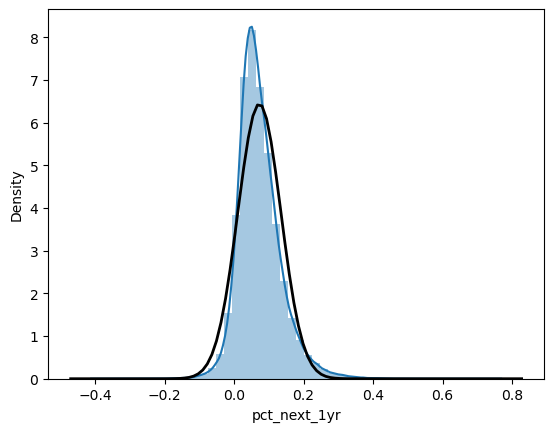

In [14]:
# look at distribution
sns.distplot(dfz4['pct_next_1yr'])
# add normal distribution overlay
mu, std = dfz4['pct_next_1yr'].mean(), dfz4['pct_next_1yr'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
print("Skewness: %f" % dfz4['pct_next_1yr'].skew())
print('positive skewness means right skewed')
print("Kurtosis: %f" % dfz4['pct_next_1yr'].kurt())
print('normal dist has kurtosis of 3, higher kurt means heavier tails and sharper peak')

In [15]:
# dfz4.to_csv('zillow2.csv', index=False)

## df_fields and df_formulas
* df_fields is OK. Some NaNs in note and descr2, but those are informational -- they are not used.
* df_formulas will be used later to add calculated fields

In [16]:
# df_fields is OK. Some NaNs in note and descr2, but those are informational -- not used.
df_fields = pd.read_csv('fields1.csv')
df_fields.sample(5)

,code,myname,use_as_is,note,descr1,descr2
15,B25002_003E,vacant_units,0,divide by total units,Estimate!!Total:!!Vacant,OCCUPANCY STATUS
13,B11001_007E,non_family_households,0,divide by households. Note that fams with chil...,Estimate!!Total:!!Nonfamily households:,HOUSEHOLD TYPE (INCLUDING LIVING ALONE)
4,B23025_005E,unemployed,0,divide by population,Estimate!!Total:!!In labor force:!!Civilian la...,EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS ...
21,B25018_001E,ave_num_rooms,1,use as is,Estimate!!Median number of rooms,MEDIAN NUMBER OF ROOMS
17,B07001_049E,moved_fr_other_county,0,divide by population,Estimate!!Total:!!Moved from different county ...,GEOGRAPHICAL MOBILITY IN THE PAST YEAR BY AGE ...


In [17]:
formulas = [
    ['labor_force_perc', '(dfx.labor_force / dfx.population)', 1, 'labor force perc (0-1)'], 
    ['unemployed_perc', '(dfx.unemployed / dfx.population)', 1, 'labor force perc (0-1)'], 
    ['bach_degr_perc', '(dfx.bachelors_degr / dfx.population)', 1, 'bachelors degree perc (0-1)'], 
    ['masters_degr_perc', '(dfx.masters_degr / dfx.population)', 1, 'masters degree perc (0-1)'], 
    ['peops_per_household', '(dfx.population / dfx.num_households)', 1, 'people per household'],
    ['owner_occ_perc', '(dfx.owner_occupied / dfx.num_households)', 1, 'percent owner occupied (0-1)'],
    ['new_units_perc', '(dfx.housing_units_built_last_year / dfx.num_households)', 1, 'units built last year, percent of all units (0-1)'],
    ['families_wU18_perc', '(dfx.families_with_children / dfx.num_households)', 1, 'percent of households with kids under 18 (0-1)'],
    ['poverty_perc', '(dfx.below_poverty_level / dfx.population)', 1, 'percent below poverty level (0-1)'],
    ['non_families_perc', '(dfx.non_family_households / dfx.num_households)', 1, 'percent of non-family households (0-1)'],
    ['vacant_perc', '(dfx.vacant_units / dfx.num_households)', 1, 'percent of units that are vacant (0-1)'],
    ['perc_moved_fr_same_county', '(dfx.moved_fr_same_county / dfx.population)', 1, 'percent moved from within county (0-1)'],
    ['perc_moved_fr_other_county', '(dfx.moved_fr_other_county / dfx.population)', 1, 'percent moved from other county within state (0-1)'],
    ['perc_moved_fr_other_state', '(dfx.moved_fr_other_state / dfx.population)', 1, 'percent moved from other state (0-1)'],
    ['perc_moved_fr_abroad', '(dfx.moved_fr_abroad / dfx.population)', 1, 'percent moved from abroad (0-1)'],
    ['single_fam_perc', '(dfx.single_family_units / dfx.num_households)', 1, 'percent of units that are single family (0-1)'],
    ['public_trans_perc', '(dfx.workers_using_public_trans / dfx.workers)', 1, 'percent of workers using public trans (0-1)'],
    ['foreign_born_perc', '(dfx.foreign_born / dfx.population)', 1, 'foreign born percent (0-1)'], 
    ['male_perc', '(dfx.male / (dfx.male + dfx.female))', 1, 'male percent (M/(M+F)) (0-1)'], 
]
df_formulas = pd.DataFrame(formulas, columns=['myname', 'formula', 'use_as_is', 'note'])
df_formulas

,myname,formula,use_as_is,note
0,labor_force_perc,(dfx.labor_force / dfx.population),1,labor force perc (0-1)
1,unemployed_perc,(dfx.unemployed / dfx.population),1,labor force perc (0-1)
2,bach_degr_perc,(dfx.bachelors_degr / dfx.population),1,bachelors degree perc (0-1)
3,masters_degr_perc,(dfx.masters_degr / dfx.population),1,masters degree perc (0-1)
4,peops_per_household,(dfx.population / dfx.num_households),1,people per household
5,owner_occ_perc,(dfx.owner_occupied / dfx.num_households),1,percent owner occupied (0-1)
6,new_units_perc,(dfx.housing_units_built_last_year / dfx.num_h...,1,"units built last year, percent of all units (0-1)"
7,families_wU18_perc,(dfx.families_with_children / dfx.num_households),1,percent of households with kids under 18 (0-1)
8,poverty_perc,(dfx.below_poverty_level / dfx.population),1,percent below poverty level (0-1)
9,non_families_perc,(dfx.non_family_households / dfx.num_households),1,percent of non-family households (0-1)


## df_census
* look at nulls, mins, max. Distributions and versus dependent variable will be done later.
* Watch out for thesefields: they are denominators: population, num_households, workers, male + female

In [18]:
df_census = pd.read_csv('census1.csv')
df_census = df_census.apply(pd.to_numeric)

In [19]:
flds = df_census.describe().T
flds['nulls']=len(df_census)-flds['count']
flds

,count,mean,std,min,25%,50%,75%,max,nulls
zipcode,331854.0,4.966953e+04,2.756266e+04,601.0,26651.0000,49736.0000,72127.0000,99929.0,0.0
year,331854.0,2.016509e+03,2.876386e+00,2012.0,2014.0000,2017.0000,2019.0000,2021.0,0.0
population,331854.0,9.731664e+03,1.439819e+04,0.0,706.0000,2789.0000,13222.0000,130352.0,0.0
median_household_income,330856.0,-3.730369e+07,1.533415e+08,-666666666.0,39156.0000,50905.0000,65550.0000,250001.0,998.0
median_age,331854.0,-1.139654e+07,8.641678e+07,-666666666.0,36.4000,41.4000,46.8000,105.1,0.0
labor_force,331819.0,4.918726e+03,7.473287e+03,0.0,322.0000,1312.0000,6467.0000,68735.0,35.0
unemployed,331819.0,3.563450e+02,6.366639e+02,0.0,15.0000,82.0000,412.0000,9735.0,35.0
bachelors_degr,331854.0,1.249047e+03,2.231157e+03,0.0,50.0000,225.0000,1368.7500,29701.0,0.0
masters_degr,331854.0,5.430742e+02,1.058649e+03,0.0,15.0000,87.0000,552.0000,17950.0,0.0
num_households,331854.0,3.614666e+03,5.213188e+03,0.0,269.0000,1058.0000,4979.0000,43607.0,0.0


Drop non-sensical rows and drop state column (a better state column is in zillow)

In [20]:
print('len df_census', len(df_census))
dfc2=df_census.copy()

dropzeros=['population', 'num_households', 'workers']
dfc2 = dfc2[dfc2[dropzeros].ne(0).all(axis=1)]

dfc2.drop(dfc2[(dfc2.male + dfc2.female) == 0].index, inplace=True)

drop66 = ['median_household_income', 'median_age', 'median_rent', 'median_value', 'ave_num_rooms', 'gini', 'cost_of_living_perc', 'median_RE_tax']
dfc2 = dfc2[dfc2[drop66].ne(-666666666).all(axis=1)]

dfc2 = dfc2.drop(['state'], axis=1)

print('len dfc2', len(dfc2))


len df_census 331854
len dfc2 266825


In [26]:
flds = dfc2.describe().T
flds['nulls']=len(dfc2)-flds['count']
flds

,count,mean,std,min,25%,50%,75%,max,nulls
zipcode,266816.0,49200.315116,27386.451022,601.0000,27541.0000,49331.0000,71275.0000,9.992900e+04,0.0
year,266816.0,2016.412745,2.871381,2012.0000,2014.0000,2016.0000,2019.0000,2.021000e+03,0.0
population,266816.0,11956.050747,15233.694609,25.0000,1487.0000,4836.0000,17731.0000,1.303520e+05,0.0
median_household_income,266816.0,57492.623933,24192.009308,2499.0000,41875.0000,52436.0000,66802.2500,2.500010e+05,0.0
median_age,266816.0,41.502261,7.197170,8.9000,36.8000,41.2000,45.7000,8.630000e+01,0.0
labor_force,266816.0,6049.337993,7923.485952,7.0000,696.0000,2295.0000,8863.0000,6.873500e+04,0.0
unemployed,266816.0,438.443009,684.586132,0.0000,37.0000,145.0000,565.0000,9.735000e+03,0.0
bachelors_degr,266816.0,1541.326577,2397.563779,0.0000,112.0000,415.0000,2002.0000,2.970100e+04,0.0
masters_degr,266816.0,670.186327,1144.289931,0.0000,38.0000,163.0000,814.0000,1.795000e+04,0.0
num_households,266816.0,4451.422388,5494.299955,13.0000,582.0000,1834.0000,6791.0000,4.360700e+04,0.0


In [22]:
# nine rows seem to be a problem: they are null for many columns
dropnulls=['labor_force', 'unemployed', 'below_poverty_level', 'mean_travel_time_to_work', 'workers_using_public_trans', 'workers', 'gini', 'cost_of_living_perc']
dfc2 = dfc2.dropna(subset=dropnulls)
print('len dfc2', len(dfc2))

len dfc2 266816


In [25]:
# set some nulls to average
setave = ['median_rent', 'median_household_income', 'median_value', 'median_RE_tax']
for col in setave:
    dfc2[col].fillna(dfc2[col].mean(), inplace=True)

In [27]:
flds = dfc2.describe().T
flds['nulls']=len(dfc2)-flds['count']
flds

,count,mean,std,min,25%,50%,75%,max,nulls
zipcode,266816.0,49200.315116,27386.451022,601.0000,27541.0000,49331.0000,71275.0000,9.992900e+04,0.0
year,266816.0,2016.412745,2.871381,2012.0000,2014.0000,2016.0000,2019.0000,2.021000e+03,0.0
population,266816.0,11956.050747,15233.694609,25.0000,1487.0000,4836.0000,17731.0000,1.303520e+05,0.0
median_household_income,266816.0,57492.623933,24192.009308,2499.0000,41875.0000,52436.0000,66802.2500,2.500010e+05,0.0
median_age,266816.0,41.502261,7.197170,8.9000,36.8000,41.2000,45.7000,8.630000e+01,0.0
labor_force,266816.0,6049.337993,7923.485952,7.0000,696.0000,2295.0000,8863.0000,6.873500e+04,0.0
unemployed,266816.0,438.443009,684.586132,0.0000,37.0000,145.0000,565.0000,9.735000e+03,0.0
bachelors_degr,266816.0,1541.326577,2397.563779,0.0000,112.0000,415.0000,2002.0000,2.970100e+04,0.0
masters_degr,266816.0,670.186327,1144.289931,0.0000,38.0000,163.0000,814.0000,1.795000e+04,0.0
num_households,266816.0,4451.422388,5494.299955,13.0000,582.0000,1834.0000,6791.0000,4.360700e+04,0.0


In [28]:
df_formulas

,myname,formula,use_as_is,note
0,labor_force_perc,(dfx.labor_force / dfx.population),1,labor force perc (0-1)
1,unemployed_perc,(dfx.unemployed / dfx.population),1,labor force perc (0-1)
2,bach_degr_perc,(dfx.bachelors_degr / dfx.population),1,bachelors degree perc (0-1)
3,masters_degr_perc,(dfx.masters_degr / dfx.population),1,masters degree perc (0-1)
4,peops_per_household,(dfx.population / dfx.num_households),1,people per household
5,owner_occ_perc,(dfx.owner_occupied / dfx.num_households),1,percent owner occupied (0-1)
6,new_units_perc,(dfx.housing_units_built_last_year / dfx.num_h...,1,"units built last year, percent of all units (0-1)"
7,families_wU18_perc,(dfx.families_with_children / dfx.num_households),1,percent of households with kids under 18 (0-1)
8,poverty_perc,(dfx.below_poverty_level / dfx.population),1,percent below poverty level (0-1)
9,non_families_perc,(dfx.non_family_households / dfx.num_households),1,percent of non-family households (0-1)


## calculated census columns

In [29]:
# do the calculated fields
dfx = dfc2
for newcol, formula, ignore1, ignore2 in formulas:
    # print(newcol + ' = ' + formula)
    dfx = pd.eval(newcol + ' = ' + formula, target = dfx)

dfx.head()

,zipcode,year,population,median_household_income,median_age,labor_force,unemployed,bachelors_degr,masters_degr,num_households,...,non_families_perc,vacant_perc,perc_moved_fr_same_county,perc_moved_fr_other_county,perc_moved_fr_other_state,perc_moved_fr_abroad,single_fam_perc,public_trans_perc,foreign_born_perc,male_perc
0,2655,2012,3846,73323.0,54.6,1626.0,156.0,732,399,1699,...,0.314303,0.794585,0.060322,0.010400,0.015601,0.000000,1.656268,0.017100,0.083983,0.447998
1,2657,2012,2974,46031.0,52.9,1992.0,258.0,883,422,1687,...,0.763485,1.643154,0.035642,0.015804,0.037996,0.004707,1.133966,0.025309,0.079354,0.575656
2,2659,2012,741,51466.0,61.0,355.0,31.0,121,62,374,...,0.368984,2.278075,0.000000,0.000000,0.066127,0.000000,3.160428,0.047319,0.116059,0.464238
3,2660,2012,5881,48617.0,51.3,2835.0,173.0,976,419,2699,...,0.400519,0.588737,0.049141,0.014963,0.011733,0.000000,1.288625,0.016575,0.035368,0.477300
5,2664,2012,9562,49698.0,50.3,4899.0,425.0,1398,656,4634,...,0.447777,0.510358,0.045179,0.017151,0.046434,0.001255,1.232197,0.028906,0.104685,0.453880


In [30]:
# drop cols used in calc but not needed for models 
cols_to_drop = df_fields[df_fields['use_as_is']==0]['myname'].tolist()
dfx.drop(columns=cols_to_drop, inplace=True)

In [33]:
flds = dfx.describe().T
flds['nulls']=len(dfx)-flds['count']
flds

,count,mean,std,min,25%,50%,75%,max,nulls
zipcode,266816.0,49200.315116,27386.451022,601.000000,27541.000000,49331.000000,71275.000000,9.992900e+04,0.0
year,266816.0,2016.412745,2.871381,2012.000000,2014.000000,2016.000000,2019.000000,2.021000e+03,0.0
population,266816.0,11956.050747,15233.694609,25.000000,1487.000000,4836.000000,17731.000000,1.303520e+05,0.0
median_household_income,266816.0,57492.623933,24192.009308,2499.000000,41875.000000,52436.000000,66802.250000,2.500010e+05,0.0
median_age,266816.0,41.502261,7.197170,8.900000,36.800000,41.200000,45.700000,8.630000e+01,0.0
median_rent,266816.0,872.529874,367.595602,99.000000,633.000000,775.000000,1010.000000,3.501000e+03,0.0
mean_travel_time_to_work,266816.0,5196.409424,6801.557167,0.000000,595.000000,1980.000000,7595.000000,6.095600e+04,0.0
median_value,266816.0,193256.071831,170619.377898,9999.000000,95400.000000,143100.000000,224600.000000,2.000001e+06,0.0
ave_num_rooms,266816.0,5.712778,0.816654,1.300000,5.300000,5.700000,6.100000,1.000000e+01,0.0
gini,266816.0,0.422656,0.058691,0.091900,0.384800,0.419100,0.456900,8.139000e-01,0.0


In [32]:
# fix the remaining nulls
setave = ['perc_moved_fr_same_county', 'perc_moved_fr_other_county', 'perc_moved_fr_other_state', 'perc_moved_fr_abroad']
for col in setave:
    dfx[col].fillna(dfx[col].mean(), inplace=True)

## combine census and zillow, save df_combo

In [34]:
merged_x = dfx.merge(dfz4, on=['zipcode', 'year'], how='left', indicator=True)
not_in_dfz4 = merged_x[merged_x['_merge'] == 'left_only']
print(len(dfx), len(dfz4), len(not_in_dfz4))
not_in_dfz4['population'].describe()   # 75% of these have populations less than 591

266816 231267 49492


count     49492.000000
mean       2135.748586
std        5926.984166
min          25.000000
25%         419.000000
50%         784.000000
75%        1523.000000
max      108427.000000
Name: population, dtype: float64

In [35]:
merged_z = dfz4.merge(dfx, on=['zipcode', 'year'], how='left', indicator=True)
not_in_dfx = merged_z[merged_z['_merge'] == 'left_only']
print(len(dfx), len(dfz4), len(not_in_dfx))
# not_in_dfx.sample(20)
not2 = not_in_dfx.loc[not_in_dfx['year']!=2022]
print(len(dfx), len(dfz4), len(not_in_dfx), len(not2))
not2.sample(20)
# not_in_dfx['population'].max()   # 108k
# not_in_dfx['population'].describe()

266816 231267 13943
266816 231267 13943 13943


,zipcode,state,city,metro,county,year,typ_price,pct_next_1yr,pct_next_2yr,pct_next_3yr,...,vacant_perc,perc_moved_fr_same_county,perc_moved_fr_other_county,perc_moved_fr_other_state,perc_moved_fr_abroad,single_fam_perc,public_trans_perc,foreign_born_perc,male_perc,_merge
5925,3215,NH,Waterville Valley,"Lebanon, NH-VT",Grafton County,2017,201496.263575,0.031976,0.035713,0.128794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
227604,98283,WA,Rockport,"Mount Vernon-Anacortes, WA",Skagit County,2019,262744.651508,0.220194,0.406197,0.525310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58397,24844,WV,Iaeger,NaN,McDowell County,2020,52105.684676,-0.004388,-0.124668,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
25831,12420,NY,Pine Bush,"Kingston, NY",Ulster County,2013,183113.772707,0.065415,0.163533,0.263661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
41780,17727,PA,Cedar Run,"Williamsport, PA",Lycoming County,2021,181044.343274,0.149730,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
16704,7822,NJ,Augusta,"New York-Newark-Jersey City, NY-NJ-PA",Sussex County,2021,455893.717522,0.028952,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
54317,23106,VA,Aylett,"Richmond, VA",King William County,2019,217859.817728,0.107282,0.251371,0.369061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
223277,97028,OR,Welches,"Portland-Vancouver-Hillsboro, OR-WA",Clackamas County,2021,510414.103377,0.107304,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
25472,12193,NY,Westerlo,"Albany-Schenectady-Troy, NY",Albany County,2014,170819.628105,0.015542,0.055711,0.070778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
201277,84059,UT,Vineyard,"Provo-Orem, UT",Utah County,2018,339635.068799,0.066984,0.195662,0.490649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [36]:
dfcombo = dfx.merge(dfz4, on=['zipcode', 'year'], how='inner')
print(dfcombo.shape)
dfcombo.head()

(217324, 46)


,zipcode,year,population,median_household_income,median_age,median_rent,mean_travel_time_to_work,median_value,ave_num_rooms,gini,...,pct_next_1yr,pct_next_2yr,pct_next_3yr,pct_next_4yr,pct_next_5yr,pct_next_6yr,pct_next_7yr,pct_next_8yr,pct_next_9yr,pct_next_10yr
0,2655,2012,3846,73323.0,54.6,1265.0,1394.0,443500.0,6.8,0.5339,...,0.051160,0.087641,0.110632,0.164412,0.205938,0.263887,0.296016,0.440883,0.852849,1.068989
1,2657,2012,2974,46031.0,52.9,936.0,1517.0,467100.0,3.7,0.5349,...,0.093282,0.240235,0.322248,0.418350,0.558377,0.646149,0.698518,0.809535,1.239531,1.500159
2,2659,2012,741,51466.0,61.0,1208.0,285.0,469800.0,5.5,0.3777,...,0.041903,0.087301,0.152702,0.187533,0.248760,0.293473,0.315354,0.438934,0.789102,1.074293
3,2660,2012,5881,48617.0,51.3,1055.0,2469.0,342800.0,5.4,0.4286,...,0.052785,0.080764,0.146780,0.200872,0.297018,0.349806,0.392865,0.539608,0.879304,1.089731
4,2664,2012,9562,49698.0,50.3,1271.0,4149.0,303800.0,5.1,0.4380,...,0.059477,0.086348,0.147343,0.225341,0.287225,0.352833,0.394227,0.548728,0.859606,1.108462


In [37]:
dfcombo.to_csv('combo.csv', index=False)

In [ ]:
dfcombo.info()

In [38]:
flds = dfcombo.describe().T
flds['nulls']=len(dfcombo)-flds['count']
flds

,count,mean,std,min,25%,50%,75%,max,nulls
zipcode,217324.0,48161.549309,27812.434636,1001.000000,25315.000000,47171.000000,71241.000000,9.990100e+04,0.0
year,217324.0,2016.619789,2.857517,2012.000000,2014.000000,2017.000000,2019.000000,2.021000e+03,0.0
population,217324.0,14192.464555,15809.836341,25.000000,2512.000000,7483.000000,21630.000000,1.303520e+05,0.0
median_household_income,217324.0,60253.622380,24950.906483,2499.000000,43789.750000,54638.500000,70286.000000,2.500010e+05,0.0
median_age,217324.0,41.236737,6.945752,15.900000,36.700000,40.900000,45.200000,8.430000e+01,0.0
median_rent,217324.0,923.939557,374.824226,99.000000,671.000000,821.000000,1074.000000,3.501000e+03,0.0
mean_travel_time_to_work,217324.0,6207.458339,7099.169141,0.000000,1035.000000,3109.000000,9409.000000,6.095600e+04,0.0
median_value,217324.0,212311.416930,179707.665540,9999.000000,108500.000000,158200.000000,247500.000000,2.000001e+06,0.0
ave_num_rooms,217324.0,5.731863,0.833573,1.300000,5.300000,5.700000,6.200000,1.000000e+01,0.0
gini,217324.0,0.424868,0.055501,0.128000,0.388275,0.420900,0.457300,7.865000e-01,0.0


In [ ]:
# dist
def doplots(varname):
    var = dfcombo[varname]
    sns.distplot(var)

    # add normal distribution overlay
    mu, std = var.mean(), var.std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    # print some stats
    print("Skewness: %f" % var.skew())
    print('positive skewness means right skewed')
    print("Kurtosis: %f" % var.kurt())
    print('normal dist has kurtosis of 3, higher kurt means heavier tails and sharper peak')

    # add plot for this var versis independent var
    data = pd.concat([dfcombo['pct_next_1yr'], dfcombo[varname]], axis=1)
    data.plot.scatter(x=varname, y='pct_next_1yr') # , ylim=(0,800000)

